# Lake Arthur Sensor Exploratory Data Analysis
Special thank you to [Scott](https://www.gonzaga.edu/college-of-arts-sciences/departments/chemistry-biochemistry/about-the-department/staff) from the GU Chemistry department for sharing this data with us!! It is a great example of missing data :)

## Lake Arthur Overview
Lake Arthur is a small lake on the GU campus that is about 10 feet deep at its deepest point. You can see it is that long, oval lake by the Spokane river:

<img src="https://github.com/GonzagaCPSC222/U5-Visualizing-Data/raw/master/figures/lake_arthur_map.png" width="500">

If you look closely enough (or zoom in on [Google Maps](https://www.google.com/maps/place/Gonzaga+University/@47.6661608,-117.4052794,502m/data=!3m1!1e3!4m5!3m4!1s0x549e18ebbb7aeffb:0xdb160d1679b907e7!8m2!3d47.6670321!4d-117.4014343)) you can see there is a small solar panel in the lake. This solar panel powers a sensor that hangs about 5 feet below the surface of the water. The sensor records data about water temperature, oxygen saturation, etc. This data is stored locally and uploaded wirelessly to the cloud.

## Data Preprocessing (Cleaning and Restructuring)
From the cloud data source, we have hourly sensor readings from Lake Arthur spanning 5/1/2018 to 2/2/21. Let's see a summary description of this data. We also have notes from Scott explaining periods of time where data is missing. Let's take a look at the data, starting with Scott's notes so we know what we're working with!

In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel("../files/LakeArthur.xls", index_col=0)
df = df.loc[::-1] # reverse order so it is oldest first, this is just my personal preference
df = df[~df.index.duplicated(keep='first')] # there are some duplicate timestamps, like two entries for 2020-11-01 01:00:00

# print a general description
print(df.describe(), end="\n\n")

# print the available notes
for timestamp in df.index:
    note = df.loc[timestamp, "Notes(Thank you Scott!!)"]
    if not pd.isnull(note):
        print(timestamp, note, end="\n\n")

           BATT(V)  CHLOR-A(ug/L)   COND(mS/cm)      DO(mg/L)    DO%(% Sat)  \
count  2005.000000   22075.000000  22075.000000  22075.000000  22075.000000   
mean     12.388429    -424.704590    -42.627460   -419.900662   -358.749317   
std       2.050194     616.188186     61.515572    619.590550    662.418342   
min       3.110000   -1310.720000   -131.072000  -1310.720000  -1310.720000   
25%      12.710000   -1310.720000   -131.072000  -1310.720000  -1310.720000   
50%      12.940000       2.260000      0.100000     10.490000     92.760000   
75%      13.170000       3.980000      0.147000     11.870000    104.350000   
max      14.340000      74.600000      1.974000     19.680000    199.960000   

          pH(units)       Temp(C)  
count  22075.000000  22075.000000  
mean    -421.331439   -419.587845  
std      618.593130    619.830502  
min    -1310.720000  -1310.720000  
25%    -1310.720000  -1310.720000  
50%        8.570000      5.250000  
75%        8.930000     12.795000  


We have a picture documenting what the lake looked like during the "low water bad data" event:

<img src="https://github.com/GonzagaCPSC222/U5-Visualizing-Data/raw/master/figures/lake_arthur_sept_2019.jpg" width="500">

Alot of the columns have -1310.72 as their minimum value during the time periods we have notes for. This is the value that is recorded when the sensor is down. For example, let's look at the software bug in the notes above:

In [2]:
print(df.loc["2018-11-16 08:00:00": "2019-07-25 15:00:00", :])

                     BATT(V)  CHLOR-A(ug/L)  COND(mS/cm)  DO(mg/L)  \
Date/Time(PST)                                                       
2018-11-16 08:00:00      NaN           3.09        0.128     11.00   
2018-11-16 09:00:00      NaN       -1310.72     -131.072  -1310.72   
2018-11-16 10:00:00      NaN       -1310.72     -131.072  -1310.72   
2018-11-16 11:00:00      NaN       -1310.72     -131.072  -1310.72   
2018-11-16 12:00:00      NaN       -1310.72     -131.072  -1310.72   
...                      ...            ...          ...       ...   
2019-07-25 11:00:00      NaN       -1310.72     -131.072  -1310.72   
2019-07-25 12:00:00      NaN       -1310.72     -131.072  -1310.72   
2019-07-25 13:00:00      NaN       -1310.72     -131.072  -1310.72   
2019-07-25 14:00:00      NaN       -1310.72     -131.072  -1310.72   
2019-07-25 15:00:00      NaN           0.04        0.003      0.19   

                     DO%(% Sat)  pH(units)  Temp(C)  \
Date/Time(PST)                    

This means this special value marks missing data! We should replace it with `np.NaN` so we can easily take advantage of missing data functionality that comes with numpy/scipy/pandas/matplotlib.

In [3]:
df = df.replace(-1310.72, np.NaN)
print(df.isnull().sum())

BATT(V)                     20070
CHLOR-A(ug/L)                7196
COND(mS/cm)                     0
DO(mg/L)                     7197
DO%(% Sat)                   7197
pH(units)                    7197
Temp(C)                      7197
Notes(Thank you Scott!!)    22069
dtype: int64


22,074 samples is a lot!! We can downsample this data to be daily instead of hourly. We can do this by getting the means for each day. To do this, we need to change the index from a plain `Index` to a `DateTimeIndex`:

In [4]:
print("Before conversion:", type(df.index))
df.index = pd.to_datetime(df.index)
print("After conversion:", type(df.index))
df = df.resample("1D").mean()
print(df["Temp(C)"]) # note the "Freq: D" for daily frequency

Before conversion: <class 'pandas.core.indexes.base.Index'>
After conversion: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Date/Time(PST)
2018-05-01          NaN
2018-05-02    10.590000
2018-05-03    10.850000
2018-05-04    11.600000
2018-05-05    12.005000
                ...    
2021-01-28     3.698750
2021-01-29     3.906667
2021-01-30     4.191667
2021-01-31     4.469167
2021-02-01     4.524000
Freq: D, Name: Temp(C), Length: 1008, dtype: float64


## Visualize the Data
Let's visualize the data. We can start with the temperature since it is the most straightforward to interpret :)

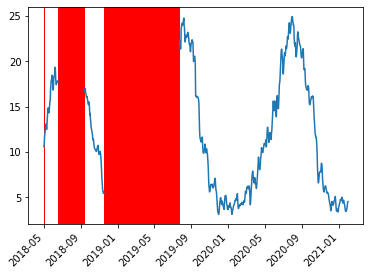

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_missing_values(df, col_name):
    plt.plot(df.index, df[col_name])
    for timestamp in df.index:
        value = df.loc[timestamp, col_name]
        if pd.isnull(value):
            plt.axvspan(timestamp, timestamp, color="red")
    plt.xticks(rotation=45, ha="right")
    plt.show()

plot_missing_values(df, "Temp(C)")

Notice the missing data is represented as blanks in the chart. This is good, this clearly shows us the windows of missing data. It seems that there is a chunk of missing data in mid-2018 that we don't have a note for... I wonder what happened then?

Anyways, this presents a fun opportunity to fill continuous numeric data and to easily visualize the effects of various filling approaches. Let's start with an interpolation of the missing temperature data w/[interpolate()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html):

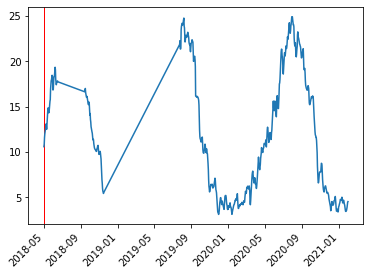

In [6]:
filled_df = df.interpolate()
plot_missing_values(filled_df, "Temp(C)")

And now a forward fill of the missing temperature data w/[fillna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html):

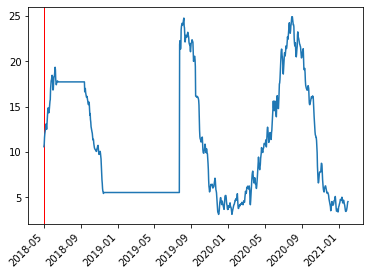

In [7]:
filled_df = df.ffill()
plot_missing_values(filled_df, "Temp(C)")

And lastly, a backward fill of the missing temperature data w/[fillna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html):

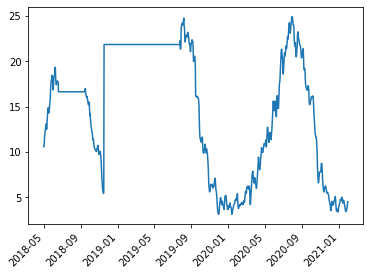

In [8]:
filled_df = df.bfill()
plot_missing_values(filled_df, "Temp(C)")